<a href="https://colab.research.google.com/github/darthwaydr007/kaggle/blob/master/Plant_pathology_updated1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
!pip uninstall torch -y
!pip uninstall torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0
!curl -s https://course.fast.ai/setup/colab | bash
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!pip install --upgrade --force-reinstall --no-deps kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/kaggle/plant-pathology/input1/.kaggle/"
os.environ['KAGGLE_USERNAME'] = "harditya007"
os.environ['KAGGLE_KEY'] = "0250e56a32fa57989ed751274890f675"
%cd /content/drive/My Drive/kaggle/plant-pathology/input1

Uninstalling torch-1.5.0+cu101:
  Successfully uninstalled torch-1.5.0+cu101
Uninstalling torchvision-0.6.0+cu101:
  Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 47.0MB/s 
Updating fastai...
Done.
     |████████████████████████████████| 61kB 3.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=599c3274d353a3918ecb98cec3e4c777cd6eacf9e6167e9cdb9a0dfea97b8b0b
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6
/content/drive/My Drive/kaggle/plant-pathology/input1


Run the below cell to download data from kaggle competetion

In [0]:
'''
!kaggle competitions download -c plant-pathology-2020-fgvc7
!unzip plant-pathology-2020-fgvc7
'''

'\n!kaggle competitions download -c plant-pathology-2020-fgvc7\n!unzip plant-pathology-2020-fgvc7\n'

# Data Processing

In [0]:
import numpy as np 
import pandas as pd 
from fastai.vision import *

from pathlib import Path

In [0]:
path = path = Path('/content/drive/My Drive/kaggle/plant-pathology/input1/')
traindf = pd.read_csv(path/'train.csv')
testdf = pd.read_csv(path/'test.csv')
traindf.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


Label Preprocessing

In [0]:
traindf1 = pd.DataFrame()
traindf1['id'] = traindf['image_id']
traindf1['label'] = np.zeros(len(traindf1))
for i in range(0,len(traindf1)):
  if traindf['healthy'][i] == 1:
    traindf1['label'][i] = 'healthy'
  elif traindf['multiple_diseases'][i] == 1:
    traindf1['label'][i] = 'multiple_diseases'
  elif traindf['rust'][i] == 1:
    traindf1['label'][i] = 'rust'
  elif traindf['scab'][i] == 1:
    traindf1['label'][i] = 'scab'
traindf1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,id,label
0,Train_0,scab
1,Train_1,multiple_diseases
2,Train_2,healthy
3,Train_3,rust
4,Train_4,healthy


Test Data

In [0]:
testdf["image_id"] = testdf["image_id"] + ".jpg"
test_data = ImageList.from_df(testdf, path/'images')

## Creating Transforms and DataBunch
Refer Data Block API

In [0]:
np.random.seed(42)
src = (ImageList.from_df(traindf1, path, folder='images', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df())

For Transforms use flip_vert with caution

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05)
data = (src.transform(tfms, size=224))
data = data.add_test(test_data)
data = data.databunch( bs = 64).normalize(imagenet_stats)
#data.show_batch(rows=3, figsize=(12,9))

# General steps to be followed
Find lr -> fit_one_cycle -> unfreeze -> find lr -> fit_one_cycle

Create model skeleton

In [0]:
doc(cnn_learner)

Check gpu avaliability

In [0]:
'''
learn = cnn_learner(data, arch, metrics=[accuracy, roc_score], ps=0.5, wd=1e-1).to_fp16()
learn.lr_find()
learn.recorder.plot(suggestion=True)
learn.fit_one_cycle(5, slice(lr))
learn.save('stage-1-rn50')
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, lr/5))
learn.recorder.plot_losses()
'''

"\nlearn = cnn_learner(data, arch, metrics=[accuracy, roc_score], ps=0.5, wd=1e-1).to_fp16()\nlearn.lr_find()\nlearn.recorder.plot(suggestion=True)\nlearn.fit_one_cycle(5, slice(lr))\nlearn.save('stage-1-rn50')\nlearn.unfreeze()\nlearn.fit_one_cycle(5, slice(1e-5, lr/5))\nlearn.recorder.plot_losses()\n"

## Resnet34

In [0]:
arch = models.resnet34
learn = cnn_learner(data, arch, metrics=[accuracy , error_rate], wd=1e-1).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [0]:
lr = 1e-2/2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.364634,0.607293,0.824176,0.175824,10:07
1,0.969161,0.567534,0.848901,0.151099,02:13
2,0.732677,0.440874,0.868132,0.131868,02:03
3,0.603986,0.360596,0.887363,0.112637,02:04
4,0.506056,0.350776,0.881868,0.118132,02:05


In [0]:
learn.save('1F16-resnet34-0')

In [0]:
learn.load('1F16-resnet34-0')

In [0]:
learn.unfreeze()
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(5, slice(1e-4 , 1e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.326237,0.376813,0.895604,0.104396,02:04
1,0.328251,1.925146,0.774725,0.225275,02:04
2,0.303305,0.261518,0.936813,0.063187,02:04
3,0.258662,0.222707,0.945055,0.054945,02:04
4,0.206224,0.216675,0.947802,0.052198,02:04


In [0]:
learn.save('1F16-resnet34-1')

In [0]:
learn.unfreeze()
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(4, slice(1e-5 , 1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.125828,0.195497,0.953297,0.046703,02:05
1,0.140294,0.189856,0.958791,0.041209,02:03
2,0.130805,0.191391,0.958791,0.041209,02:03
3,0.124549,0.190236,0.964286,0.035714,02:05


In [0]:
learn.save('1F16-resnet34-2')

In [0]:
preds, y = learn.get_preds(DatasetType.Test)
preds_np = preds.numpy()
px = pd.DataFrame(preds_np)
submit1 = pd.read_csv(path/"sample_submission.csv")
submit1.healthy = px[0]
submit1.multiple_diseases = px[1]
submit1.rust = px[2]
submit1.scab = px[3]
submit1.to_csv(path/"submission-34-2.csv", index = False)

In [0]:
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(3, slice(1e-6))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.125109,0.187943,0.964286,0.035714,02:04
1,0.121696,0.190371,0.967033,0.032967,02:05
2,0.117041,0.194713,0.961538,0.038462,02:04


In [0]:
learn.fit_one_cycle(3, slice(1e-6) , wd = 2e-1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.117098,0.192309,0.961538,0.038462,02:06
1,0.109251,0.195370,0.967033,0.032967,02:06
2,0.108016,0.192860,0.961538,0.038462,02:06


In [0]:
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [0]:
preds, y = learn.get_preds(DatasetType.Test)
preds_np = preds.numpy()
px = pd.DataFrame(preds_np)
submit2 = pd.read_csv(path/"sample_submission.csv")
submit2.healthy = px[0]
submit2.multiple_diseases = px[1]
submit2.rust = px[2]
submit2.scab = px[3]
submit2.to_csv(path/"submission-34-4.csv", index = False)

## Resnet50

In [0]:
arch = models.resnet50
learn1 = cnn_learner(data, arch, metrics=[accuracy , error_rate], wd=1e-1).to_fp16()
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
learn1.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.120415,1.000087,0.829670,0.170330,02:10
1,0.778660,0.389749,0.879121,0.120879,02:09
2,0.589000,0.313407,0.884615,0.115385,02:09
3,0.461760,0.283125,0.892857,0.107143,02:12
4,0.363114,0.285852,0.895604,0.104396,02:13


In [0]:
learn1.save('1F16-resent50-1')
learn1.unfreeze()
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [0]:
learn1.fit_one_cycle(5, slice(3e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.274079,0.319770,0.920330,0.079670,02:15
1,0.297872,0.379930,0.909341,0.090659,02:13
2,0.307487,0.351968,0.936813,0.063187,02:15
3,0.257954,0.152516,0.945055,0.054945,02:14
4,0.209422,0.145531,0.953297,0.046703,02:13


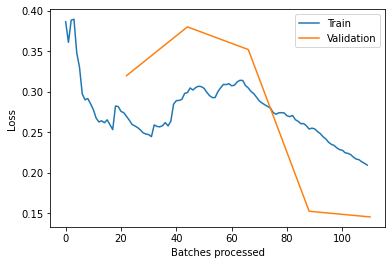

In [0]:
learn1.recorder.plot_losses()

In [0]:
learn1.save('1F16-resent50-2')

In [0]:
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [0]:
learn1.fit_one_cycle(5, slice(2e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.147027,0.139015,0.961538,0.038462,02:10
1,0.145910,0.131921,0.967033,0.032967,02:09
2,0.137267,0.130437,0.967033,0.032967,02:10
3,0.118084,0.121717,0.972527,0.027473,02:09
4,0.105856,0.123122,0.972527,0.027473,02:09


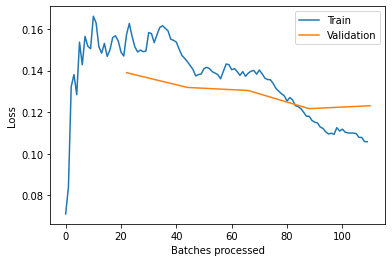

In [0]:
learn1.recorder.plot_losses()

In [0]:
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [0]:
learn1.save('1F16-resent50-3')

In [0]:
preds, y = learn1.get_preds(DatasetType.Test)
preds_np = preds.numpy()
px = pd.DataFrame(preds_np)
submit3 = pd.read_csv(path/"sample_submission.csv")
submit3.healthy = px[0]
submit3.multiple_diseases = px[1]
submit3.rust = px[2]
submit3.scab = px[3]
submit3.to_csv(path/"submission-50-3.csv", index = False)

In [0]:
learn1.fit_one_cycle(3, slice(2e-5, (1e-4)/2) , wd = 0.2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.097740,0.134456,0.969780,0.030220,02:09
1,0.092024,0.138160,0.972527,0.027473,02:09
2,0.085557,0.134059,0.975275,0.024725,02:09


In [0]:
learn1.save('1F16-resent50-4')

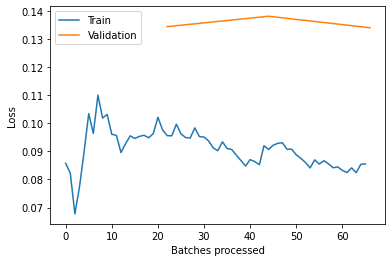

In [0]:
learn1.recorder.plot_losses()

In [0]:
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [0]:
learn1.fit_one_cycle(4, slice(3e-6, 1e-5) , wd = 0.2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.087615,0.134047,0.972527,0.027473,02:11
1,0.089208,0.133514,0.972527,0.027473,02:10
2,0.080548,0.129404,0.969780,0.030220,02:11
3,0.077197,0.128559,0.972527,0.027473,02:10


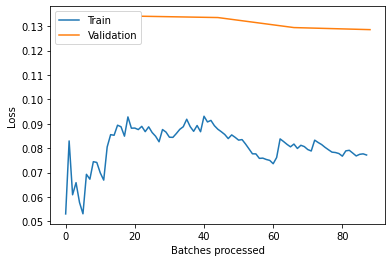

In [0]:
learn1.recorder.plot_losses()

In [0]:
learn1.save('1F16-resent50-4')

In [0]:
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [0]:
learn1.fit_one_cycle(4, slice(2e-6) , wd = 0.15)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.083341,0.135974,0.969780,0.030220,02:08
1,0.089493,0.131549,0.969780,0.030220,02:10
2,0.079436,0.130425,0.972527,0.027473,02:09
3,0.078350,0.131857,0.972527,0.027473,02:10


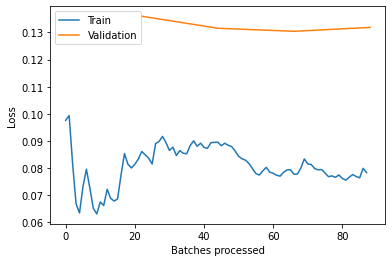

In [0]:
learn1.recorder.plot_losses()

In [0]:
learn1.save('1F16-resent50-5')

In [0]:
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [0]:
learn1.fit_one_cycle(8, slice(1e-6 , 1e-5) , wd = 0.06)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.068550,0.133175,0.972527,0.027473,02:09
1,0.058648,0.132884,0.969780,0.030220,02:10
2,0.081060,0.132848,0.972527,0.027473,02:10
3,0.082779,0.131075,0.972527,0.027473,02:11
4,0.075326,0.129264,0.972527,0.027473,02:11
5,0.076020,0.134201,0.972527,0.027473,02:12
6,0.077215,0.130438,0.972527,0.027473,02:09
7,0.078314,0.130443,0.969780,0.030220,02:11


In [0]:
learn1.save('1F16-resent50-6')

In [0]:
preds, y = learn1.get_preds(DatasetType.Test)
preds_np = preds.numpy()
px = pd.DataFrame(preds_np)
submit4 = pd.read_csv(path/"sample_submission.csv")
submit4.healthy = px[0]
submit4.multiple_diseases = px[1]
submit4.rust = px[2]
submit4.scab = px[3]
submit4.to_csv(path/"submission-50-61.csv", index = False)